
# Slim parameters



---

Variables to allow differentation of file names for analyses based on different calling criteria. Should be commented out when run in batch with `slurm-jupyter-run.py`

**NB:** comment out the cell below if you want to run using `slurm-jupyter-run.py`. Otherwise it will overwrite variables set by `slurm-jupyter-run.py`.

In [1]:
from nb_parameters import extract_parameter_code
exec(extract_parameter_code('nb_parameters.ipynb', '5e-05_25%'))

----

In [2]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%%html
<style> table { font-variant-numeric: tabular-nums; } </style>

Import variables global to the entire analysis:

In [4]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [5]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

Plotting setup:

In [6]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("whitegrid")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

def abline(slope, intercept, ax=None):
    "Add a straight line through the plot"
    if ax is None:
        ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='grey')

In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/e

Ignore warnings:

In [7]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Load meta data

Easy loading of meta data in a consistent manner across code

In [8]:
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=ag.meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Load swept regions

To account for the recombination rate and genetic diversity caracteristic of the ECH regions we operationally define these regions as the ones where at least 10% of individual chromososomes are called as ECH:

In [9]:
extended_peak_regions_10 = pd.read_hdf(ag.results_dir / f'extended_peak_regions_{ech_calling_tag}_10%.hdf')
extended_peak_regions_10['chrom'] = 'chrX'
ech_total_10 = (extended_peak_regions_10.end_pos - extended_peak_regions_10.start_pos).sum()
ech_total_10

17500000

This is this many percent of the total chromosome length:

In [10]:
ech_total_10 / hg19_chrom_sizes.hg19_chrom_sizes['chrX'] * 100

11.270649117257

## Extract pi on X chromosome for Africans and non-Africans

In [11]:
dist_afr = (pd.read_hdf(ag.steps_dir / 'male_dist_admix_masked_stores/male_dist_data_chrX_100kb.hdf')
            .loc[lambda df: (df.region_1 == 'Africa') & (df.region_2 == 'Africa')]
           )
dist_nonafr = (pd.read_hdf(ag.steps_dir / 'male_dist_admix_masked_stores/male_dist_data_chrX_100kb.hdf')
            .loc[lambda df: (df.region_1 != 'Africa') & (df.region_2 != 'Africa')]
           )
dist_nonafr.head()

,chrom,start,end,pop_label,indiv_1,pseud_1,indiv_2,pseud_2,dist,mismatch,...,longitude_1,longitude_2,sex_1,sex_2,region_label_1,region_label_2,region_id_1,region_id_2,region_1,region_2
34144,X,0,100000,NA,B_Crete-2,A,S_Tujia-1,A,0.000000,0,...,NaN,109.000000,XY,XY,WestEurasia,EastAsia,1,5,WestEurasia,EastAsia
130368,X,0,100000,NA,B_Crete-2,A,S_BedouinB-1,A,0.008130,2,...,NaN,35.000000,XY,XY,WestEurasia,WestEurasia,1,1,WestEurasia,WestEurasia
225040,X,0,100000,NA,B_Crete-2,A,S_Burusho-1,A,0.000000,0,...,NaN,74.000000,XY,XY,WestEurasia,SouthAsia,1,2,WestEurasia,SouthAsia
391104,X,0,100000,NA,B_Crete-2,A,S_Punjabi-2,A,0.005882,2,...,NaN,74.300003,XY,XY,WestEurasia,SouthAsia,1,2,WestEurasia,SouthAsia
529232,X,0,100000,NA,B_Crete-2,A,S_Makrani-1,A,0.006154,2,...,NaN,64.000000,XY,XY,WestEurasia,SouthAsia,1,2,WestEurasia,SouthAsia


In [12]:
afr_mean_dist = dist_afr.dist.mean()
nonafr_mean_dist = dist_nonafr.dist.mean()

In [13]:
afr_mean_dist, nonafr_mean_dist, nonafr_mean_dist / afr_mean_dist

(0.0007654295, 0.00046199292, 0.60357344)

## Extract likely pi relative to global pi in Africans

In [14]:
lst = list()
for tup in extended_peak_regions_10.itertuples():
    lst.append(dist_afr.loc[(dist_afr.start >= tup.start_pos) & (dist_afr.end <= tup.end_pos)])
afr_dist_regions = pd.concat(lst)

lst = list()
for tup in extended_peak_regions_10.itertuples():
    lst.append(dist_nonafr.loc[(dist_nonafr.start >= tup.start_pos) & (dist_nonafr.end <= tup.end_pos)])
nonafr_dist_regions = pd.concat(lst)

In [15]:
afr_mean_dist_in_regions = afr_dist_regions.dist.mean()
nonafr_mean_dist_in_regions = nonafr_dist_regions.dist.mean()

If we assume that the regions have not experienced any sweeps in Africa, we can compute the locan Ne of regions relative to the global chromosome Ne:

In [16]:
afr_mean_dist_in_regions, afr_mean_dist, afr_mean_dist_in_regions / afr_mean_dist

(0.0005436191, 0.0007654295, 0.71021444)

This implies that background Ne in the regions is 0.71 of the chromosome average.

## Compute demographies

We simulate 200,000 generations, correspoding to roughly 10 Ne. Most lineages should have coalesced by 6Ne.

In [17]:
sim_generations = 200000 - 1
x_auto_fraction = 0.55

def years2gen(y):
    "Compute forwards generation from backwards time"
    return int(1 + sim_generations - y / ag.gen_time)

years2gen(sim_generations * ag.gen_time), years2gen(0), sim_generations * ag.gen_time

(1, 200000, 5799971)

## Sweeps

Time points for starts fo simulated sweeps:

In [18]:
sweep_years = [30000, 50000, 70000, 90000]

Compute generations for sweeps in Slim simulations (for adding to `workflow.py`):

In [19]:
sweep_generations = [years2gen(x) for x in sweep_years]
sweep_generations

[198965, 198275, 197586, 196896]

## Demographies

As a first stab i visually extracted a non-African demography from the figure from Terhorst et al.

### Terhorst
We make a descrete trajectory approximating the demography from Yun Songs paper: Terhorst et al. 2017

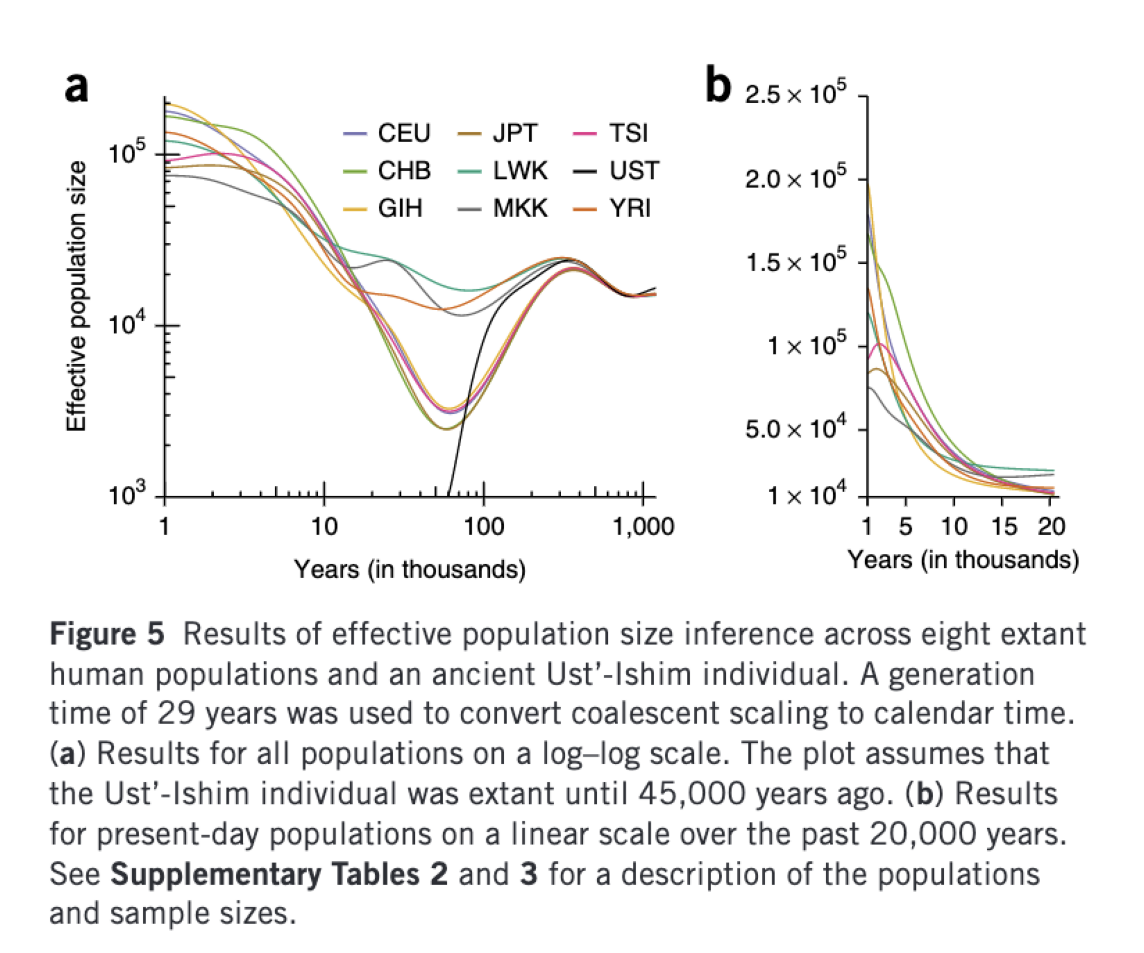

In [20]:
from matplotlib.image import imread
fig, ax = plt.subplots(figsize=(10, 10))
imgplot = ax.imshow(imread('Terhorst2017.png'))
plt.axis('off') ;

In this paper, the demography is based on a mutation rate per generation of 1.25 × 10−8. That is roughly the same as in my analysis:

In [21]:
ag.mut_per_year * ag.gen_time

1.247e-08

Demography is specified as descrete breakpoints and effective population sizes, approximated from inspecting the figure above:

In [22]:
terhorst_changes_year = [sim_generations * ag.gen_time, 700000, 250000, 150000, 100000, 70000, 45000, 35000, 25000, 15000, 8000, 3000]
terhorst_changes_Ne = [18000, 20000, 12000, 6000, 4000, 3000, 4000, 6000, 12000, 20000, 50000, 100000]

Adjust population sizes slightly to make the demography produce the the empirical mean 100kb pairwise differences across non-African populations in our data set. This makes most sense since we we want to simulate replicates of the acctual data set.

In [23]:
correction_to_fit_autosomal_pi = 1.09
terhorst_changes_Ne = [x * correction_to_fit_autosomal_pi for x in terhorst_changes_Ne]

### Tennesen

This is the demography we use for simulations. It is often cited at the Tennessen demography, but it is actually from a Gravel paper:
 
Gravel et al. "Demographic history and rare allele sharing among human populations". 

We use the CEU demography file that we have from Aron Stern's CLUES paper.

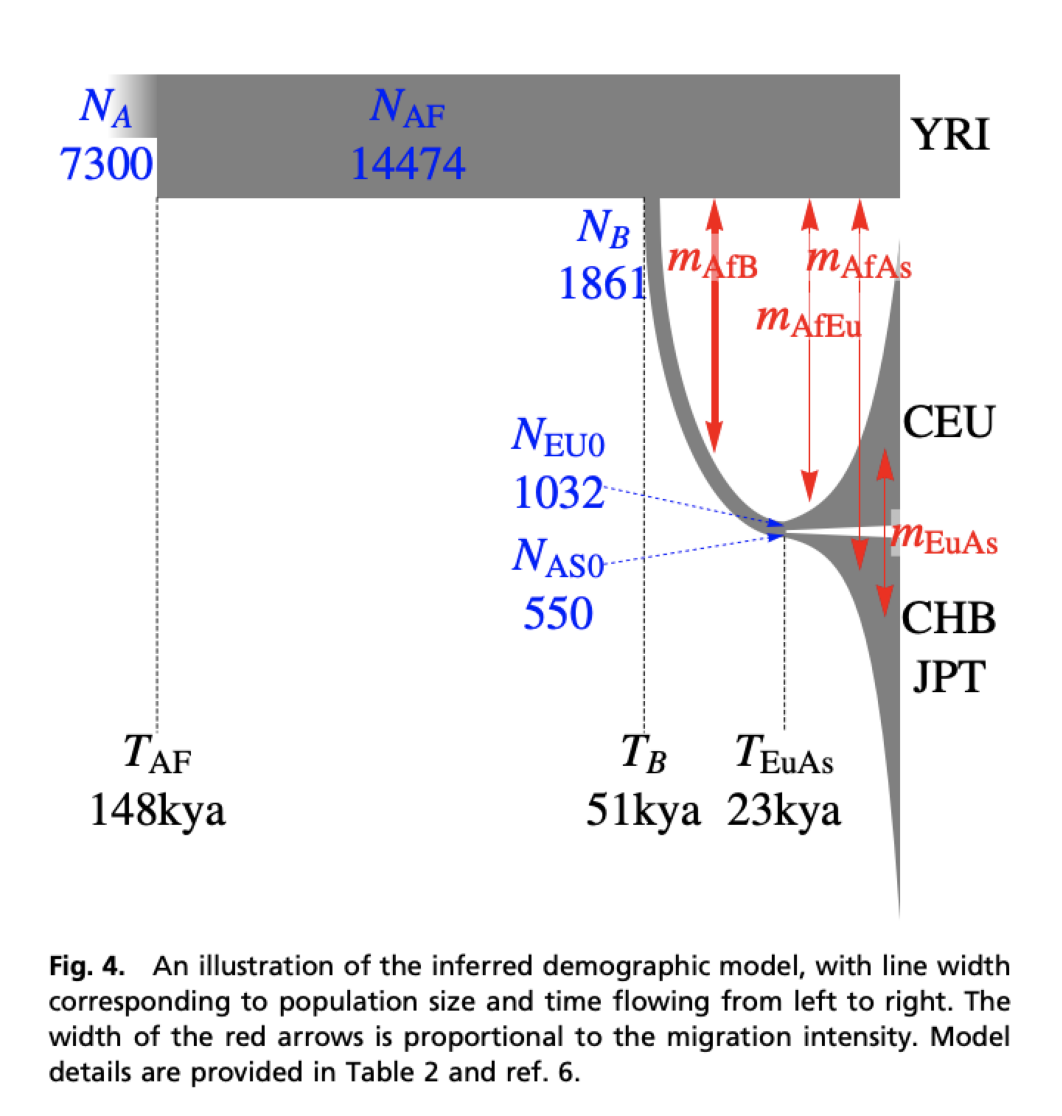

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
imgplot = ax.imshow(imread('Tennessen.png'))
plt.axis('off') ;

Load demography data and rescale population sizes to fit the generation time and mutation rate assumed in this study:

In [25]:
# load Compare to "tennessen_fine"
tennessen = pd.read_csv('/home/kmt/simons/faststorage/people/kmt/data/tennessen_popsize_fine.txt', sep='\t', header=None, names=['start', 'popsize'])

tennessen_mut_rate_per_gen = 2.36e-08
tennessen_generation_time = 25
tennessen['popsize'] *= tennessen_mut_rate_per_gen / (ag.mut_per_year * ag.gen_time) 
tennessen['start'] = tennessen.start * tennessen_generation_time * 2
tennessen = tennessen[:-1] # drop last row because we do not want to simulate all the way back from 15 mill years.

tennessen['end'] = tennessen.start.shift(-1)

tennessen.at[len(tennessen)-1, 'end'] = sim_generations * ag.gen_time
tennessen = stairs(tennessen)

tennessen.tail()

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(tennessen)

,start,popsize,end,pos
36,1750000,13832.590217,2500000.0,2500000.0
37,2500000,13834.482759,5000000.0,2500000.0
37,2500000,13834.482759,5000000.0,5000000.0
38,5000000,13834.482759,5799971.0,5000000.0
38,5000000,13834.482759,5799971.0,5799971.0


## Slim full autosomal demography

Generate the full and truncated demographies and plot them to make sure they are correct:

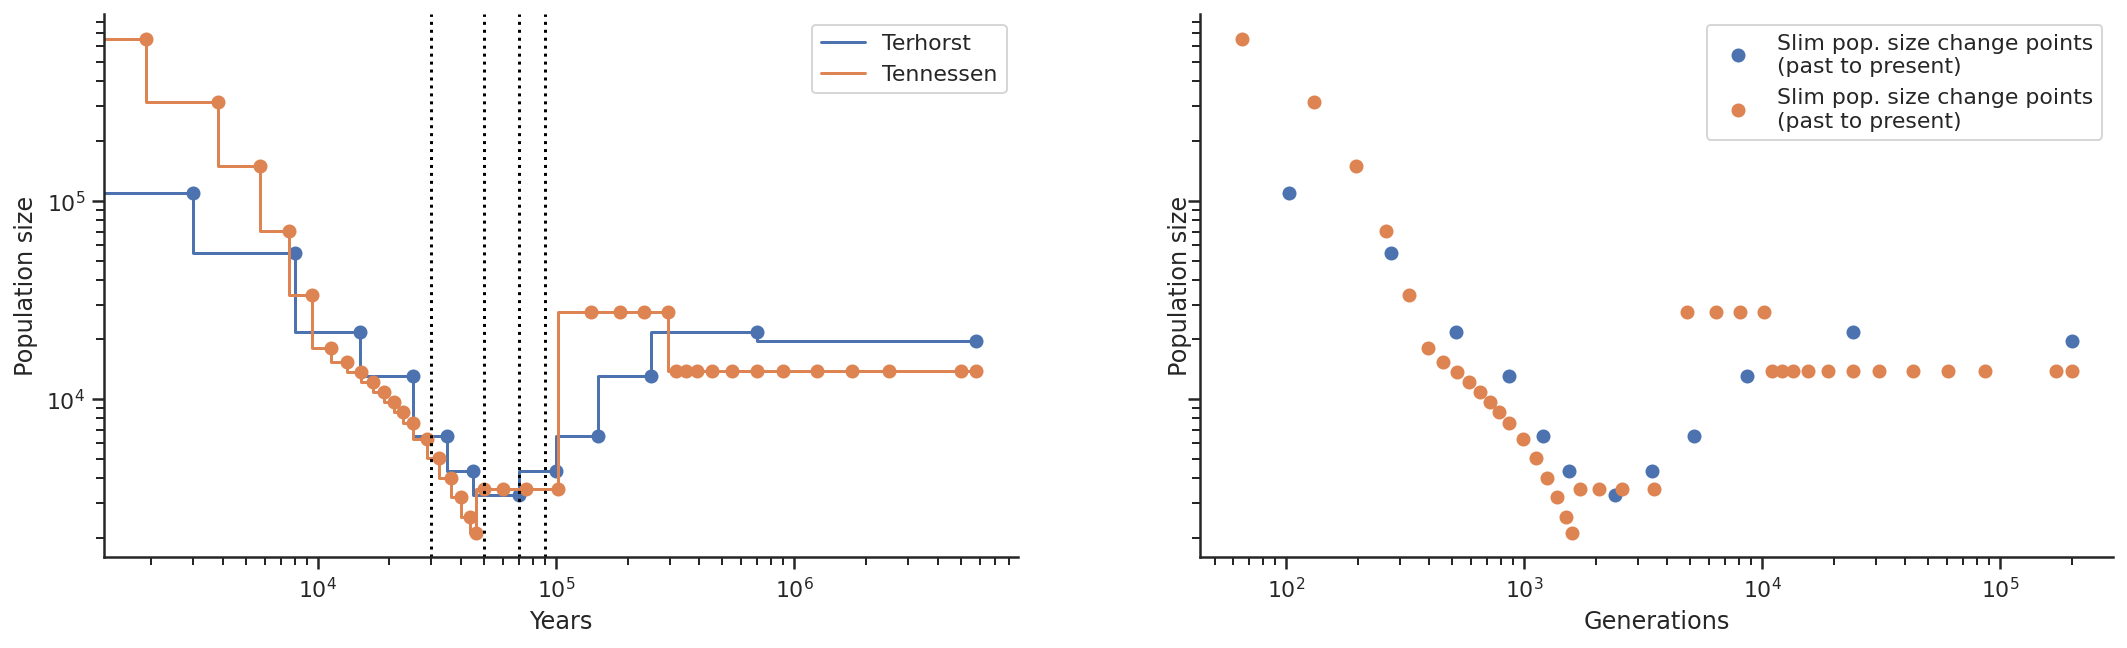

In [26]:
with sns.axes_style('ticks') :

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5), sharey=True)

    y = Series(list(reversed(terhorst_changes_year)))
    n = Series(list(reversed(terhorst_changes_Ne)))
    x = [j for i in zip(y.shift(), y) for j in i]
    y = [j for i in zip(n, n) for j in i]
    x[0] = 0

    terhorst_auto_demography = list(zip(reversed(x[1::2]), reversed(y[1::2])))
    color=next(ax1._get_lines.prop_cycler)['color']
    ax1.loglog(x, y, color=color, label='Terhorst')
    ax1.loglog(*list(zip(*terhorst_auto_demography)), marker='o', color=color, linestyle='None');

    # tennessen
    color=next(ax1._get_lines.prop_cycler)['color']
    ax1.loglog(tennessen.pos, tennessen.popsize, color=color, label='Tennessen')
    tennessen_x, tennssen_y = tennessen.pos.tolist(), tennessen.popsize.tolist()
    tennessen_auto_demography = list(zip(reversed(tennessen_x[1::2]), reversed(tennssen_y[1::2])))
    ax1.loglog(*list(zip(*tennessen_auto_demography)), marker='o', color=color, linestyle='None');

    ax1.set_xlabel('Years')
    ax1.set_ylabel('Population size')
    ax1.legend()

#     y = Series(list(reversed(changes_year)))
#     n = Series(list(reversed(changes_Ne))) * x_auto_fraction
#     x = [j for i in zip(y.shift(), y) for j in i]
#     y = [j for i in zip(n, n) for j in i]
#     x[0] = 1000

    # sweeps:
    [ax1.axvline(x, linestyle='dotted', color='black') for x in sweep_years]
    
    
    terhorst_slim_demography = [(years2gen(y), int(n)) for (y, n) in terhorst_auto_demography]  ## using auto
    g, n = list(zip(*terhorst_slim_demography))
    ax2.loglog([sim_generations-x for x in g], n, marker='o', linestyle='None', 
               label='Slim pop. size change points\n(past to present)');

    tennessen_slim_demography = [(years2gen(y), int(n)) for (y, n) in tennessen_auto_demography]  ## using auto
    g, n = list(zip(*tennessen_slim_demography))
    ax2.loglog([sim_generations-x for x in g], n, marker='o', linestyle='None', 
               label='Slim pop. size change points\n(past to present)');
    
    
    
#     ax2.set_ylim(1000, 120000)
#     ax2.set_xlim(1e2, 2.2e5) ;
#     ax1.set_xlim(left=1e4)




    ax2.set_xlabel('Generations')
    ax2.set_ylabel('Population size')
    ax2.legend()
    

    sns.despine()

## Slim truncated autosomal demography

Truncate simulation at 45000 years. 

If we then call ECHs with pwdiff of 2 * 10000 * 0.6e-9 = 1.2e-05, we can test if ECH can arise neutrally in 10000 years (from 55000)



In [27]:
terhorst_changes_year, _ = zip(*terhorst_auto_demography)
terhorst_changes_year_trunc = [x - 45000 for x in terhorst_changes_year]
idx = terhorst_changes_year_trunc.index(0)+1
terhorst_changes_year_trunc = terhorst_changes_year_trunc[:idx]
terhorst_changes_Ne_trunc = terhorst_changes_Ne[:idx]

In [28]:
tennessen_changes_year, tennessen_changes_Ne = zip(*tennessen_auto_demography)
tennessen_changes_year_trunc = [x - 45000 for x in tennessen_changes_year if x > 45000] + [0]
tennessen_changes_Ne_trunc = tennessen_changes_Ne[:len(tennessen_changes_year_trunc)]

In [29]:
def years2gen_trunc(y):
    return int(1 + sim_generations - (45000 / ag.gen_time) - y / ag.gen_time)

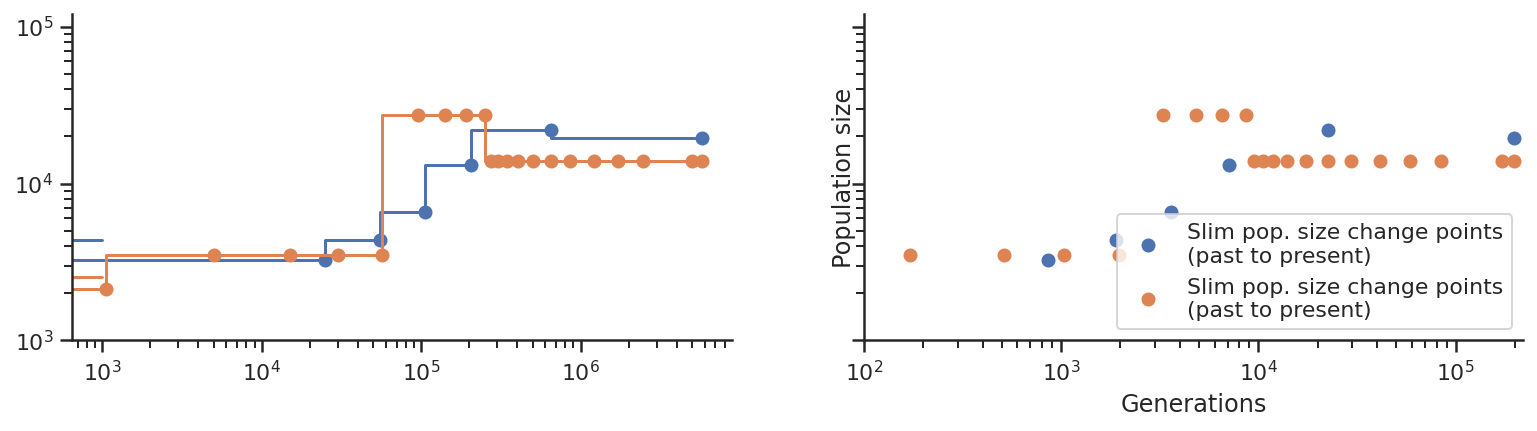

In [30]:
with sns.axes_style('ticks') :

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,3), sharey=True)

    y = Series(list(reversed(terhorst_changes_year_trunc)))
    n = Series(list(reversed(terhorst_changes_Ne_trunc)))
    x = [j for i in zip(y.shift(), y) for j in i]
    y = [j for i in zip(n, n) for j in i]
    x[0] = 1000

    terhorst_auto_demography = list(zip(reversed(x[1::2]), reversed(y[1::2])))

    color=next(ax1._get_lines.prop_cycler)['color']
    ax1.loglog(x, y, color=color)
    ax1.loglog(*list(zip(*terhorst_auto_demography)), marker='o', color=color, linestyle='None', label='Autosomes');
    
    terhorst_slim_demography_trunc = [(years2gen_trunc(y), int(n)) for (y, n) in terhorst_auto_demography]  ## using auto
    g, n = list(zip(*terhorst_slim_demography))
    ax2.loglog([sim_generations-(45000/ag.gen_time)-x for x in g], n, marker='o', linestyle='None', 
               label='Slim pop. size change points\n(past to present)');
    
    
    y = Series(list(reversed(tennessen_changes_year_trunc)))
    n = Series(list(reversed(tennessen_changes_Ne_trunc)))
    x = [j for i in zip(y.shift(), y) for j in i]
    y = [j for i in zip(n, n) for j in i]
    x[0] = 1000

    tennessen_auto_demography = list(zip(reversed(x[1::2]), reversed(y[1::2])))

    color=next(ax1._get_lines.prop_cycler)['color']
    ax1.loglog(x, y, color=color)
    ax1.loglog(*list(zip(*tennessen_auto_demography)), marker='o', color=color, linestyle='None', label='Autosomes');
    
    tennessen_slim_demography_trunc = [(years2gen_trunc(y), int(n)) for (y, n) in tennessen_auto_demography]  ## using auto
    g, n = list(zip(*tennessen_slim_demography))
    ax2.loglog([sim_generations-(45000/ag.gen_time)-x for x in g], n, marker='o', linestyle='None', 
               label='Slim pop. size change points\n(past to present)');

    
    ax2.set_ylim(1000, 120000)
    ax2.set_xlim(1e2, 2.2e5) ;
    ax2.set_xlabel('Generations')
    ax2.set_ylabel('Population size')
    ax2.legend()

    sns.despine()

## Pool-Nielsen computations for sanity checks on Tennessen demography

In [31]:
def get_epoques_from_demog(demography):
    epoques = list()
    g, n = list(zip(*demography))
    gens, Ns = [sim_generations-x for x in g][::-1], n[::-1]
    for i in range(len(gens)):
        if i == 0:
            epoques.append((gens[i], Ns[i]))
        elif i == len(gens) - 1:
            epoques.append((None, Ns[i]))    
        else:
            epoques.append((gens[i] - gens[i-1], Ns[i]))
    return epoques
        
# epoques = get_epoques_from_demog(terhorst_slim_demography)
epoques = get_epoques_from_demog(tennessen_slim_demography)

In [32]:
def exp_coal(g, N):
    return 2*N - (g * np.exp(-g/(2*N))) / (1 - np.exp(-g/(2*N)))

def epoch(demog, h, i):
    g, N = demog[i]
    N *= h
    if i == len(demog)-1:
        return 2*N
    return (1-np.exp(-g/(2*N))) * exp_coal(g, N) + np.exp(-g/(2*N)) * (g + epoch(demog, h, i+1))

### Fit demography to observed autosomal pi

Compute the expected non-African autosomal Ne assuming the demography:

In [33]:
epoch(epoques, 1, 0) / 2

11780.311603551978

Compare the observed mean autosomal pi in out data set:

In [34]:
pool_nielsen_expected_pi = 2 * ag.mut_per_year * ag.gen_time * epoch(epoques, 1, 0)
pool_nielsen_expected_pi

0.0005876019427851726

This does not match mean pi across non-African populations which is 0.000683 (see notebook 1). We scale demography to make the it produce the empirical mean 100kb pairwise differences across non-African populations in our data set. This makes most sense since we we want to simulate replicates of the acctual data set.

Compute factor that expectation and observation differ:

In [35]:
pool_nielsen_correction = 0.000683 / (pool_nielsen_expected_pi + 0.000011)
pool_nielsen_correction

1.1409919533874888

A linear scaling does not compompletely do the job because not all historical population sizes contribute equally. So we add a small `tweak` value by trial and error to make the demography produce the observed pi:

In [36]:
# compute correction
tweak = 0.000011
pool_nielsen_correction = 0.000683 / (pool_nielsen_expected_pi + tweak)
pool_nielsen_correction

# correct
tennessen_slim_demography_corrected = [(g, int(round(N*pool_nielsen_correction))) for (g, N) in tennessen_slim_demography]
tennessen_slim_demography_trunc_corrected = [(g, int(round(N*pool_nielsen_correction))) for (g, N) in tennessen_slim_demography_trunc]

# recompute epoques
epoques = get_epoques_from_demog(tennessen_slim_demography_corrected)
#epoques = get_epoques_from_demog(tennessen_slim_demography)

2 * ag.mut_per_year * ag.gen_time * epoch(epoques, 1, 0), 0.000683


(0.0006838801551522859, 0.000683)

In [37]:
assert (2 * ag.mut_per_year * ag.gen_time * epoch(epoques, 1, 0)) - 0.000683 < 1e-6

tennessen_slim_demography = tennessen_slim_demography_corrected
tennessen_slim_demography_trunc = tennessen_slim_demography_trunc_corrected

### See if demography produces the X/A ratios reported in Mallick et al

Reading off from the plot in Mallick et al., the African X/A pi is 0.66 and the non-African one is 0.55.

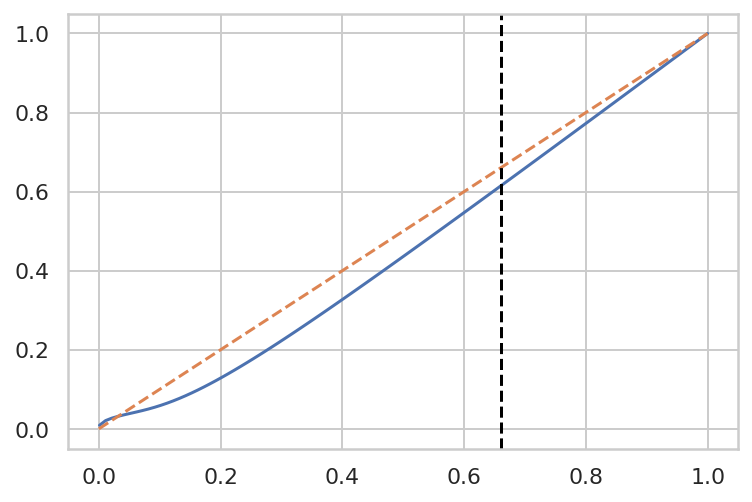

In [38]:
x = np.linspace(0.001, 1, 100)
y = [epoch(epoques, h, 0) / epoch(epoques, 1, 0) for h in x]
plt.plot(x, y) ;
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle='dashed')
plt.axvline(0.66, color='black', linestyle='dashed') ;
# plt.axhline(0.6, color='black', linestyle='dashed') ;
# plt.axhline(0.57, color='black', linestyle='dashed') ;

We do not necessarily expect X chromosome pi to match the expectation from the demography if sweeps play a role in reducing pi. The demography does produce an expected non-African X/A pi that is a bit smaller than that reported in Mallick et al.:

In [39]:
epoch(epoques, 0.66, 0) / epoch(epoques, 1, 0)

0.6142090683411263

In [40]:
2 * ag.mut_per_year * ag.gen_time * epoch(epoques, 0.66, 0), nonafr_mean_dist

(0.0004200453929530704, 0.00046199292)

In fact, if we assume that sweeps remove half of diversity in the 14% we report as covered by ECHs, then the expected pi matches that of the demography:

In [41]:
missing_proportion = 0.5 * 0.14#ech_total_10 / hg19_chrom_sizes.hg19_chrom_sizes['chrX']
(1 / (1 - missing_proportion) * epoch(epoques, 0.66, 0)) / epoch(epoques, 1, 0)

0.6604398584313186

## Find recombination rates relevant for simulations

Lift over regions to hg38

In [42]:
print(extended_peak_regions_10[['chrom', 'start_pos', 'end_pos']].to_string(index=False))

chrom  start_pos    end_pos
 chrX   19300000   20400000
 chrX   20700000   21700000
 chrX   35900000   37100000
 chrX   37000000   37800000
 chrX   49500000   50000000
 chrX   50800000   51300000
 chrX   53900000   54700000
 chrX   64400000   65200000
 chrX   72700000   73500000
 chrX   73800000   74400000
 chrX   76700000   77400000
 chrX   98300000   99200000
 chrX  109200000  111600000
 chrX  113800000  114500000
 chrX  126400000  127700000
 chrX  129500000  130200000
 chrX  130900000  132300000
 chrX  132400000  133100000
 chrX  153900000  154500000


Used online liftover to convert to hg38 allowing, un-checking box to dis-allow multiple output regions. Minimum ratio of bases that must remap to 0.9 (default is 0.95, but that makes one region not remap, it does so at 0.93). Otherwise default parameters. Result pasted in below:

In [43]:
# lifted = '''
# chrX	19281882	20381882	chrX:19300001-20400000	1
# chrX	20681882	21681882	chrX:20700001-21700000	1
# chrX	35881883	37080183	chrX:35900001-37100000	1
# chrX	36981927	37940747	chrX:37000001-37800000	1
# chrX	49735397	50209447	chrX:49500001-50000000	1
# chrX	50057375	50057403	chrX:49500001-50000000	2
# chrX	51057154	51557148	chrX:50800001-51300000	1
# chr2	33174181	33174306	chrX:50800001-51300000	2
# chrX	53873573	54673567	chrX:53900001-54700000	1
# chrX	65180120	65980158	chrX:64400001-65200000	1
# chrX	73480164	74280165	chrX:72700001-73500000	1
# chrX	74580165	75180165	chrX:73800001-74400000	1
# chrX	77448201	78144503	chrX:76700001-77400000	1
# chrX	99045002	99945002	chrX:98300001-99200000	1
# chrX	109956772	112356772	chrX:109200001-111600000	1
# chrX	114565551	115265429	chrX:113800001-114500000	1
# chrX	78550431	78550462	chrX:113800001-114500000	2
# chrX	114761888	114761918	chrX:113800001-114500000	3
# chrX	114761888	114761980	chrX:113800001-114500000	4
# chrX	127266017	128566022	chrX:126400001-127700000	1
# chrX	130366026	131066026	chrX:129500001-130200000	1
# chrX	131765972	133165972	chrX:130900001-132300000	1
# chrX	133265972	133965973	chrX:132400001-133100000	1
# chrX	154671726	155270710	chrX:153900001-154500000	1
# '''

<!-- Conversion failed for :

    #Partially deleted in new
    chrX	37000000	37800000 -->

In [44]:
lifted = '''
chrX	19281882	20381882
chrX	20681882	21681882
chrX	35881883	37080183
chrX	36981927	37940747
chrX	49735397	50209447
chrX	51057154	51557148
chrX	53873573	54673567
chrX	65180120	65980158
chrX	73480164	74280165
chrX	74580165	75180165
chrX	77448201	78144503
chrX	99045002	99945002
chrX	109956772	112356772
chrX	114565551	115265429
chrX	127266017	128566022
chrX	130366026	131066026
chrX	131765972	133165972
chrX	133265972	133965973
chrX	154671726	155270710
'''

Extract recombination rates for regions:

In [45]:
records = list()
for row in lifted.strip().split('\n'):
    records.append([x.isdigit() and int(x) or x for x in row.split()])
extended_peak_regions_10_hg38 = pd.DataFrame.from_records(records, 
#                                     columns=['chrom', 'start', 'end', 'segment', 'piece'])
                                    columns=['chrom', 'start', 'end'])
extended_peak_regions_10_hg38.head()

,chrom,start,end
0,chrX,19281882,20381882
1,chrX,20681882,21681882
2,chrX,35881883,37080183
3,chrX,36981927,37940747
4,chrX,49735397,50209447


Load recombination rate from Halldorsson et al. 2019: "Characterizing mutagenic effects of recombination through a sequence-level genetic map". Rates are per generation, also for the X chromosome (i.e. the maternal rate and sex average rates are the same).

In [46]:
decode_sexavg = pd.read_table(ag.data_dir / 'decode_hg38_sexavg_per_gen.tsv', comment='#')
decode_sexavg.head()

,Chr,Begin,End,cMperMb,cM
0,chr1,1431813,1515567,0.032449,0.002718
1,chr1,1515567,1530002,0.189597,0.005455
2,chr1,1530002,1534402,0.004631,0.005475
3,chr1,1534402,1538787,0.019865,0.005562
4,chr1,1538787,1541864,0.000332,0.005563


Mean rate of (similar sized) chromosome 7 and mean autosomal rate:

In [47]:
decode_sexavg_chr7 = decode_sexavg.loc[(decode_sexavg['Chr'] == 'chr7')]
mean_rate_chr7 = np.average(decode_sexavg_chr7.cMperMb, weights=decode_sexavg_chr7.End-decode_sexavg_chr7.Begin)
mean_rate_chr7

1.1278006767458615

Mean rate for entire X chromosome excluding PARs:

In [48]:
decode_sexavg_chrX = (decode_sexavg
                      .loc[(decode_sexavg['Chr'] == 'chrX') & \
                           (decode_sexavg['Begin'] > ag.par1_end) & (decode_sexavg['End'] < ag.par2_start)]
                     )
mean_rate = np.average(decode_sexavg_chrX.cMperMb, weights=decode_sexavg_chrX.End-decode_sexavg_chrX.Begin)
mean_rate

1.1628671122887646

In [49]:
records = list()
for tup in extended_peak_regions_10_hg38.itertuples():
    single_reg = decode_sexavg_chrX.loc[(decode_sexavg_chrX.Begin >= tup.start) & \
                                         (decode_sexavg_chrX.End <= tup.end)]

    np.average(single_reg.cMperMb, weights=single_reg.End-single_reg.Begin)
    
    records.append(( np.average(single_reg.cMperMb, weights=single_reg.End-single_reg.Begin), 
                    (single_reg.End-single_reg.Begin).sum()))

region_mean_rates = pd.DataFrame().from_records(records, columns=['mean_rate', 'tot_length'])
region_mean_rates

,mean_rate,tot_length
0,7.714961e-01,1090037
1,1.479958e-01,995497
2,5.999632e-01,1174337
3,6.853079e-01,928294
4,4.367416e-01,465754
5,3.881414e-01,460999
6,6.182831e-01,796095
7,6.045130e-02,787887
8,5.536945e-02,754082
9,3.336512e-02,478934


Mean (sex averaged) per-generation recombination rate for all sequence spanned by regions:

In [50]:
df_list = list()
for tup in extended_peak_regions_10_hg38.itertuples():
    df_list.append(decode_sexavg_chrX.loc[(decode_sexavg_chrX.Begin >= tup.start) & (decode_sexavg_chrX.End <= tup.end)])
df = pd.concat(df_list)

In [51]:
extended_peak_regions_10_mean_rate = np.average(df.cMperMb, weights=df.End-df.Begin)
extended_peak_regions_10_mean_rate

0.4614656569905098

Plot distribution of recombination rate in 1Mb windows along X chromosome to see how typical the lower recombination rates are:

In [52]:
decode_sexavg_chrX.head()

,Chr,Begin,End,cMperMb,cM
1122949,chrX,3532526,3533229,2.641418e-01,0.000186
1122950,chrX,3533229,3534231,1.352181e+00,0.001541
1122951,chrX,3534231,3535643,2.552302e-64,0.001541
1122952,chrX,3535643,3551002,2.618438e-60,0.001541
1122953,chrX,3551002,3580516,1.997509e-54,0.001541


In [53]:
@window(size=1000000)
def mean_window_rate(df):
    if len(df):
        return np.average(df.cMperMb, weights=df.end-df.start)
    else:
        return np.nan

window_means_1mb = mean_window_rate(decode_sexavg_chrX.rename(columns={'Begin':'start', 'End':'end'}))
#window_means_1mb.head()

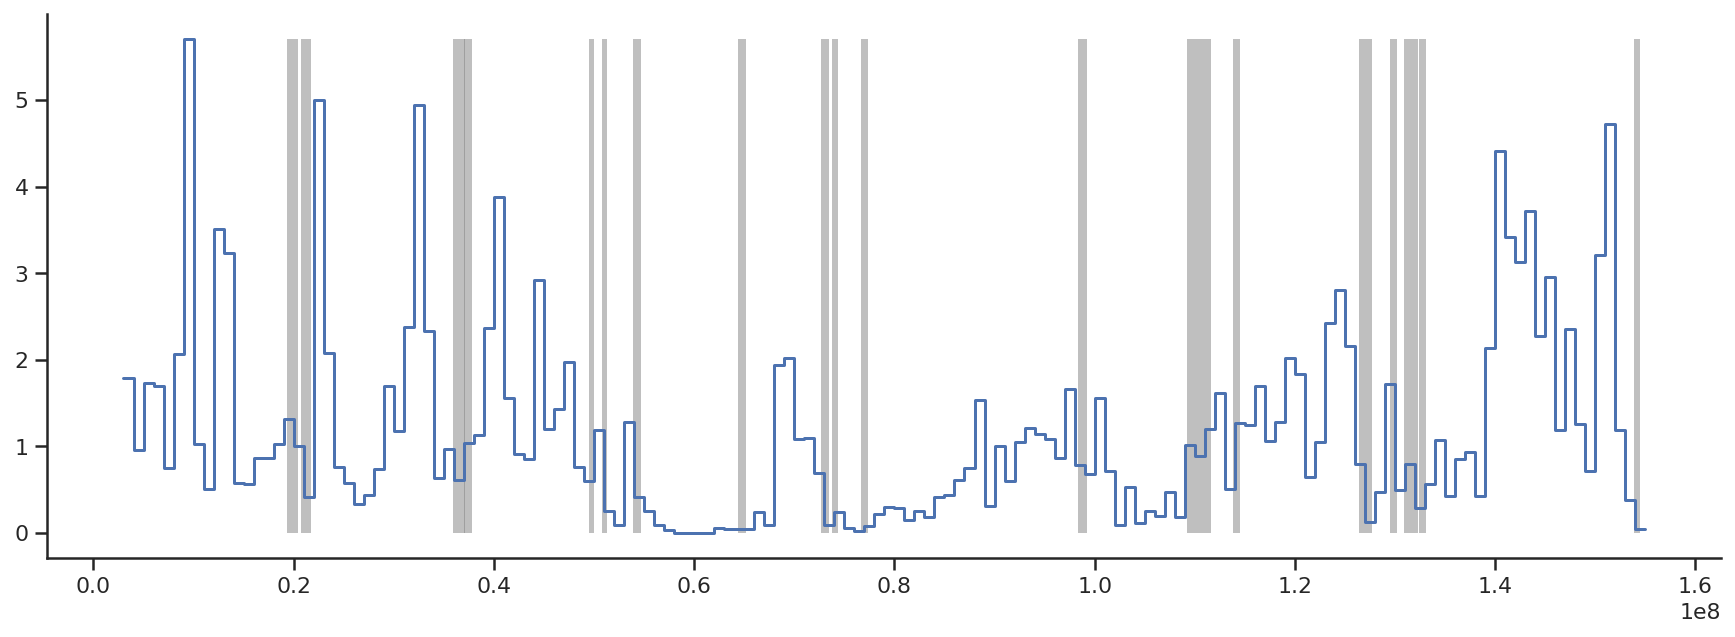

In [54]:
with sns.axes_style('ticks'):
    plot_df = stairs(window_means_1mb)
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    for tup in extended_peak_regions_10.itertuples():
        g = ax.add_patch(Rectangle((tup.start_pos, 0), 
                                   tup.end_pos-tup.start_pos, plot_df.mean_window_rate.max(), 
                     facecolor='gray',
                     linewidth=0,
                     alpha=0.5,
                     zorder=0))
    plt.plot(plot_df.pos, plot_df.mean_window_rate)
    sns.despine()

In [55]:
@window(size=100000)
def mean_window_rate(df):
    if len(df):
        return np.average(df.cMperMb, weights=df.end-df.start)
    else:
        return np.nan

window_means_100kb = mean_window_rate(decode_sexavg_chrX.rename(columns={'Begin':'start', 'End':'end'}))
#window_means_100kb.head()

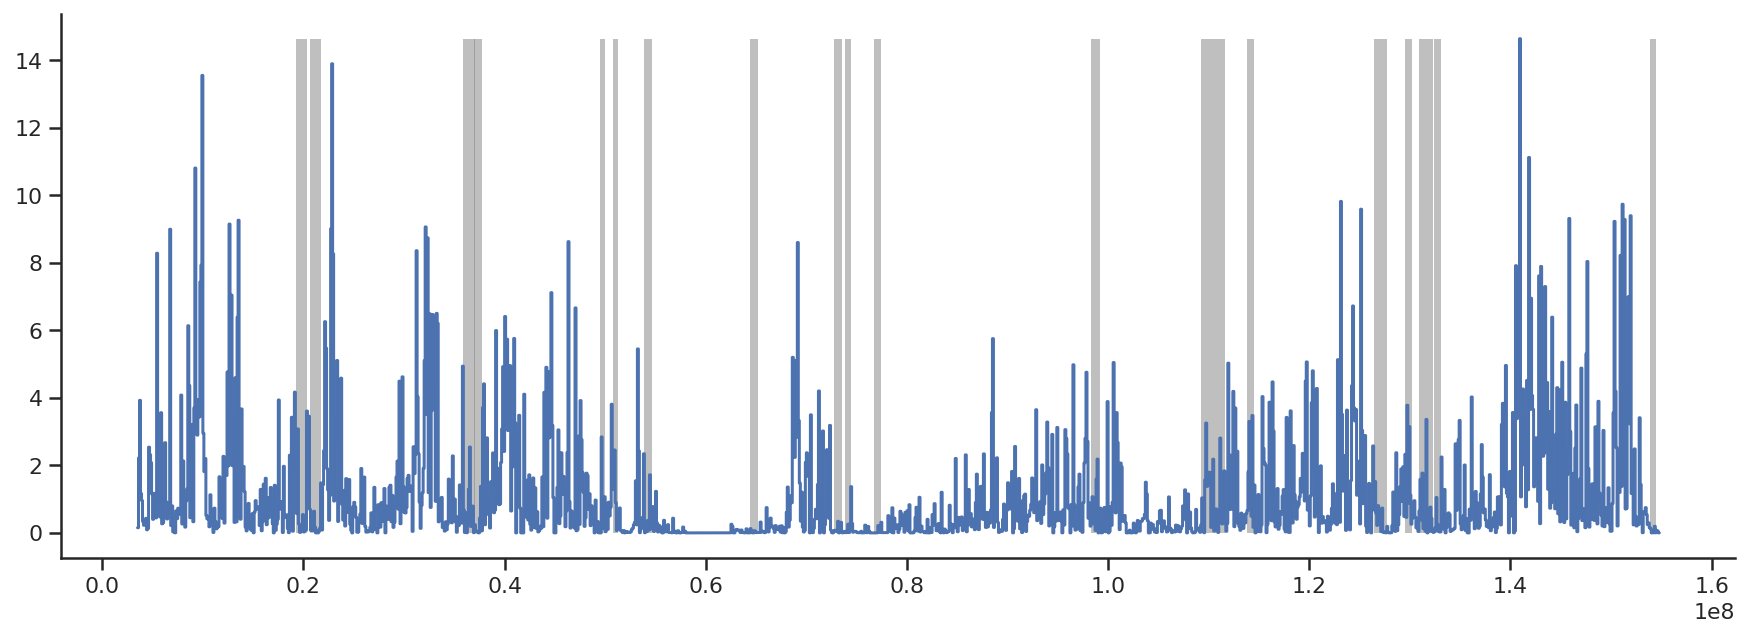

In [56]:
with sns.axes_style('ticks'):
    plot_df = stairs(window_means_100kb)
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    for tup in extended_peak_regions_10.itertuples():
        g = ax.add_patch(Rectangle((tup.start_pos, 0), 
                                   tup.end_pos-tup.start_pos, plot_df.mean_window_rate.max(), 
                     facecolor='gray',
                     linewidth=0,
                     alpha=0.5,
                     zorder=0))
    plt.plot(plot_df.pos, plot_df.mean_window_rate)
    sns.despine()

So although the ECH regions have lower recombination rate, they are not uniquely low. There are plenty other regions that are equally low.

See where each ECH region falls in the distribution of recombination rate in 500kb windows:

In [57]:
@window(size=500000)
def mean_window_rate(df):
    if len(df):
        return np.average(df.cMperMb, weights=df.end-df.start)
    else:
        return np.nan

window_means_by_chrom = (decode_sexavg
                            .rename(columns={'Chr':'chrom', 'Begin':'start', 'End':'end'})
                            .groupby('chrom')
                            .apply(mean_window_rate)
                            .reset_index()
                           )
window_means_by_chrom['chrom_type'] = 'Autosome'
window_means_by_chrom.loc[window_means_by_chrom.chrom == 'chrX', 'chrom_type'] = 'X'

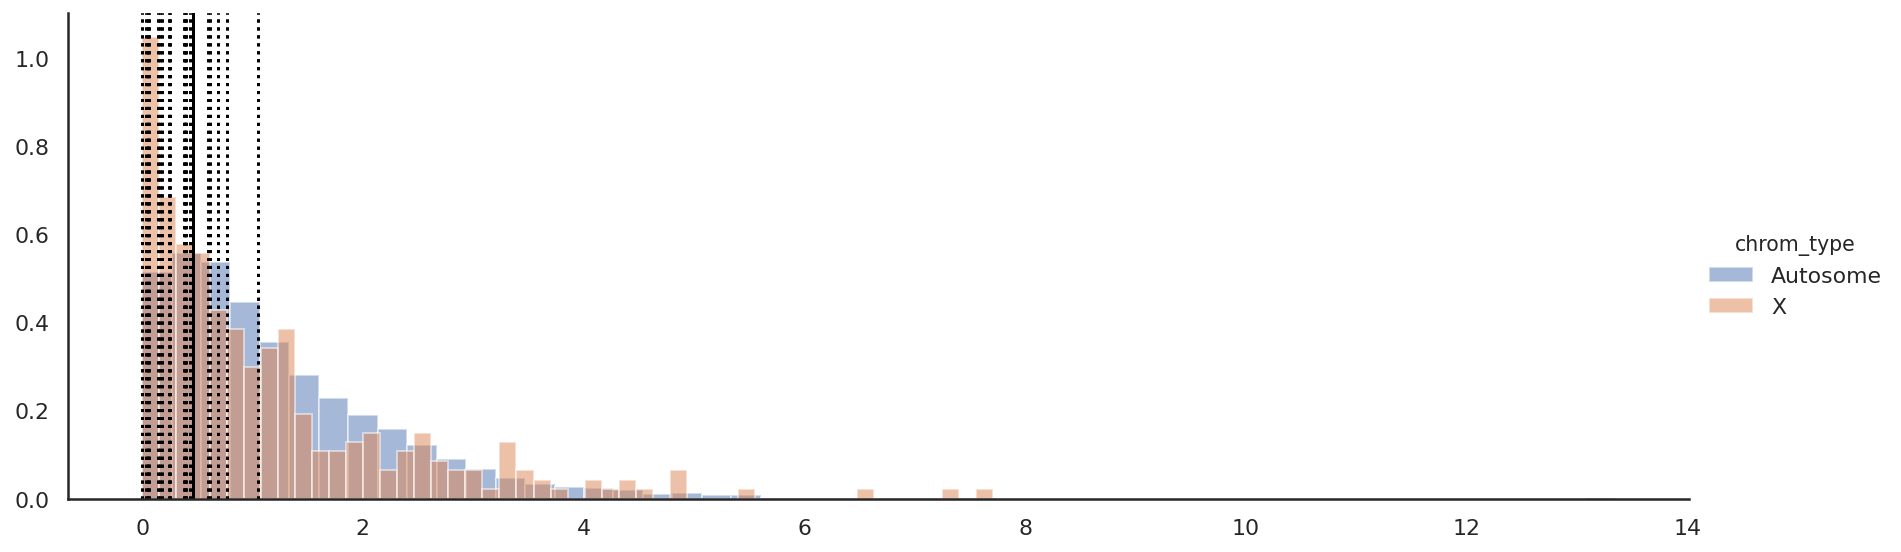

In [58]:
def axvline(x, **kwargs):
    plt.axvline(x, **kwargs)
    
with sns.axes_style('white'):
    g = sns.FacetGrid(data=window_means_by_chrom, hue='chrom_type',  
                      sharex=True, sharey=True,
                      height=4, aspect=3)
    g.map(plt.hist, 'mean_window_rate', bins=50, density=True, alpha=0.5)
    g.map(plt.axvline, x=extended_peak_regions_10_mean_rate, ls="-",  color='black') ;
    for r in region_mean_rates.mean_rate:
        g.map(plt.axvline, x=r, ls=":",  color='black') ;

    g.add_legend()

It seems that on a 500kb scale, which is the one relevant to ECHs, the mean recombination rate or ECH recions is as frequent on X than on autosomes. In fact the ECH region rate seems to the most common rate on autosomes. 

## Running SLiM simulations

### Simulation strategy

We do two sets of simulations:

1. Assuming that global averages for chrX:
    - We simulate with Ne_autosome * 3/4 * 0.66 The latter is the X/A ratio of Africans, which should capture the various demographic forces reducing Ne on X below 3/4.
    - We simulate with the mean recombination rate for X.
2. Assuming the averages for the swept regions:
    - We further reduce Ne by how much ECH region pi it is lower than the chrX mean.
    - We further reduce recombination rate by how much ECH region rate it is lower than the chrX mean.


When we compute the probability of obtaining an ECH in the latter scenario, we need to take into account that only a small part of the X has an Ne that is this low.

### Print numbers for SLIM specification:

Generation-Ne pairs for changeing population size in Slim simulation (for adding to `workflow.py`)

We use **autosomal** population sizes for Slim because it models the X chrom explicitly. To make the X/A ratio lower than 0.75 we scale the population sizes by (e.g. 0.66/0.75) when running the slim simulation.

Full demography:

In [59]:
#terhorst_slim_demography
tennessen_slim_demography

[(1, 15784),
 (27586, 15784),
 (113793, 15782),
 (139655, 15784),
 (156896, 15784),
 (168965, 15784),
 (175862, 15784),
 (181034, 15784),
 (184482, 15784),
 (186551, 15784),
 (187931, 15784),
 (188965, 15784),
 (189791, 31228),
 (191896, 31254),
 (193620, 31254),
 (195172, 31254),
 (196481, 4022),
 (197413, 4019),
 (197931, 4016),
 (198275, 4016),
 (198412, 2420),
 (198500, 2902),
 (198627, 3644),
 (198755, 4578),
 (198882, 5747),
 (199010, 7216),
 (199137, 8665),
 (199213, 9831),
 (199279, 11052),
 (199344, 12420),
 (199410, 13960),
 (199475, 15692),
 (199541, 17635),
 (199606, 20754),
 (199672, 38224),
 (199737, 80654),
 (199803, 170176),
 (199868, 359059),
 (199934, 751097)]

Truncated demography:

In [60]:
#terhorst_slim_demography_trunc
tennessen_slim_demography_trunc

[(1, 15784),
 (27586, 15784),
 (113793, 15782),
 (139655, 15784),
 (156896, 15784),
 (168965, 15784),
 (175862, 15784),
 (181034, 15784),
 (184482, 15784),
 (186551, 15784),
 (187931, 15784),
 (188965, 15784),
 (189791, 31228),
 (191896, 31254),
 (193620, 31254),
 (195172, 31254),
 (196481, 4022),
 (197413, 4019),
 (197931, 4016),
 (198275, 4016),
 (198412, 2420),
 (198448, 2902)]